In [20]:
import pandas as pd 


df = pd.read_csv('coba1.tsv', sep= '\t', header=None)


df.head()

,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,lokasi strategis di jalan sumatera bandung . t...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,"makanan beragam , harga makanan di food stall ...",positive
4,"tempat unik , bagus buat foto , makanan enak ,...",positive


In [21]:
df.columns =['text', 'label']
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,lokasi strategis di jalan sumatera bandung . t...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,"makanan beragam , harga makanan di food stall ...",positive
4,"tempat unik , bagus buat foto , makanan enak ,...",positive
...,...,...
3343,dapat bonus tcash 12.500 tapi tidak bisa dipak...,negative
3344,ketahuan yang bawain berita ini goblok banget ...,negative
3345,tidak berfaedah,negative
3346,itu ibu-ibu datang kerumah gue setiap tanggal1...,negative


In [23]:
df.label.value_counts()

neutral     1148
positive    1100
negative    1100
Name: label, dtype: int64

In [24]:
import re 

def lower(text):
    return text.lower()

def rmv_unn(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def rmv_nonalpha(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

#import dictionary alay untuk mapping kata2 tidak baku  
alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
#rename kolum pada dictionary 
alay_dict = alay_dict.rename(columns={0:'original',
                                    1:'replacement'})

#mengubah kata-kata yang tidak baku pada teks 
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def baku(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def preprocess(text):
    text = lower(text) # 1
    text = rmv_nonalpha(text) # 2
    text = rmv_unn(text) # 2
    text = baku(text)
    return text

df['text_clean'] = df.text.apply(preprocess)
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatra bandung temp...
2,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
3,"makanan beragam , harga makanan di food stall ...",positive,makanan beragam harga makanan di food stall ak...
4,"tempat unik , bagus buat foto , makanan enak ,...",positive,tempat unik bagus buat foto makanan enak pegaw...


In [25]:
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()

neg_label = df.loc[df['label']=='negative'].label.tolist()
neu_label = df.loc[df['label']=='neutral'].label.tolist()
pos_label = df.loc[df['label']=='positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" %(len(pos), len(neu), len(neg)))
print("Total data: %s" %len(total_data))

Pos: 1100, Neu: 1148, Neg: 1100
Total data: 3348


In [26]:
import pickle 
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open ('tokenizer.pickle', 'wb') as handle: 
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("tokenizer.pickle has been created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
print(X)
with open ('x_pad_sequences.pickle', 'wb') as handle: 
  pickle.dump(X, handle,protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has been created!')

tokenizer.pickle has been created!
[[   0    0    0 ...  588   17 4527]
 [   0    0    0 ...   16   11   11]
 [   0    0    0 ... 3057  218   46]
 ...
 [   0    0    0 ...    0    5 2565]
 [   0    0    0 ... 3934  202  122]
 [   0    0    0 ...   21 1091   46]]
x_pad_sequences.pickle has been created!


In [27]:
Y = pd.get_dummies(labels)
Y = Y.values
print(Y)

with open('y_labels.pickle', 'wb') as handle: 
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has been created!')

[[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
y_labels.pickle has been created!


In [28]:
from sklearn.model_selection import train_test_split

file = open('x_pad_sequences.pickle', 'rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle', 'rb')
Y= pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

In [29]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten 
from tensorflow.keras import backend as K


In [30]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 86, 100)           10000000  
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-03 16:16:48.346227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:16:48.679755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:16:48.958312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


268/268 [==============================] - ETA: 0s - loss: 0.7134 - accuracy: 0.6923

2022-12-03 16:17:13.469793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:17:13.565731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


268/268 [==============================] - 28s 98ms/step - loss: 0.7134 - accuracy: 0.6923 - val_loss: 0.4894 - val_accuracy: 0.8254
Epoch 2/10
268/268 [==============================] - 23s 84ms/step - loss: 0.2600 - accuracy: 0.9111 - val_loss: 0.4644 - val_accuracy: 0.8239
Epoch 3/10
268/268 [==============================] - 26s 98ms/step - loss: 0.0976 - accuracy: 0.9705 - val_loss: 0.5632 - val_accuracy: 0.8224
Epoch 4/10
268/268 [==============================] - 25s 95ms/step - loss: 0.0429 - accuracy: 0.9866 - val_loss: 0.5742 - val_accuracy: 0.8149
Epoch 5/10
268/268 [==============================] - 22s 81ms/step - loss: 0.0269 - accuracy: 0.9925 - val_loss: 0.6875 - val_accuracy: 0.7955
Epoch 6/10
268/268 [==============================] - 22s 83ms/step - loss: 0.0200 - accuracy: 0.9944 - val_loss: 0.8523 - val_accuracy: 0.8030
Epoch 7/10
268/268 [==============================] - 24s 88ms/step - loss: 0.0147 - accuracy: 0.9948 - val_loss: 0.8260 - val_accuracy: 0.7925
Epo

In [31]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Test Done')
print(matrix_test)

2022-12-03 16:20:51.445699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:20:51.553035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 24ms/step
Test Done
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       221
           1       0.82      0.84      0.83       212
           2       0.81      0.84      0.83       237

    accuracy                           0.80       670
   macro avg       0.80      0.80      0.80       670
weighted avg       0.80      0.80      0.80       670



In [32]:
import numpy as np 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
y=Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start =1):
  data_train = X[data[0]]
  target_train = y[data[0]]

  data_test = X[data[1]]
  target_test = y[data[1]]
  model = Sequential()
  model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
  model.add(LSTM(units, dropout=0.2))
  model.add(Dense(3,activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])


  adam = optimizers.Adam(lr = 0.001)
  model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
  #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
  #history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])
  history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0)
  prediction = model.predict(X_test)
  y_pred = predictions

  accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  print('Training ke-', iteration)
  print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
  print('================================')

  accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print('Rata-rata akurasi: ', average_accuracy)


/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-03 16:21:08.639164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:21:08.964884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:21:09.275107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:21:32.447220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:21:32.543242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

21/21 [==============================] - 1s 25ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       221
           1       0.82      0.84      0.83       212
           2       0.81      0.84      0.83       237

    accuracy                           0.80       670
   macro avg       0.80      0.80      0.80       670
weighted avg       0.80      0.80      0.80       670



/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-03 16:24:40.825063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:24:41.103275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:24:41.501567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:25:02.057198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:25:02.150149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

21/21 [==============================] - 1s 24ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       221
           1       0.82      0.84      0.83       212
           2       0.81      0.84      0.83       237

    accuracy                           0.80       670
   macro avg       0.80      0.80      0.80       670
weighted avg       0.80      0.80      0.80       670



/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-03 16:28:00.501023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:28:00.778245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:28:01.180574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:28:24.289288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:28:24.386561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

21/21 [==============================] - 1s 24ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       221
           1       0.82      0.84      0.83       212
           2       0.81      0.84      0.83       237

    accuracy                           0.80       670
   macro avg       0.80      0.80      0.80       670
weighted avg       0.80      0.80      0.80       670



/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-03 16:31:27.107133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:31:27.396383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:31:27.689742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:31:49.066720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:31:49.175988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

21/21 [==============================] - 1s 27ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       221
           1       0.82      0.84      0.83       212
           2       0.81      0.84      0.83       237

    accuracy                           0.80       670
   macro avg       0.80      0.80      0.80       670
weighted avg       0.80      0.80      0.80       670



/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-03 16:35:03.988683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:35:04.305582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:35:04.712375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:35:29.467139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:35:29.593414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

21/21 [==============================] - 1s 30ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       221
           1       0.82      0.84      0.83       212
           2       0.81      0.84      0.83       237

    accuracy                           0.80       670
   macro avg       0.80      0.80      0.80       670
weighted avg       0.80      0.80      0.80       670




Rata-rata akurasi:  0.8044776119402985


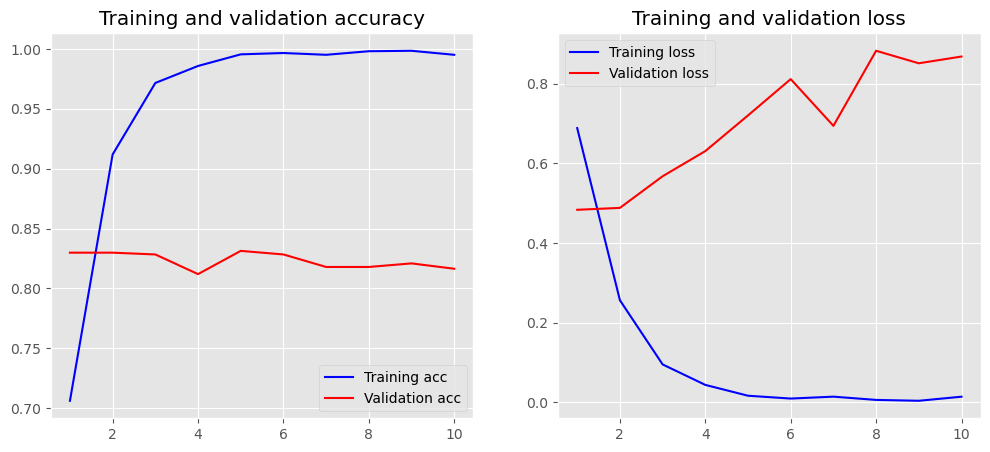

In [33]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc)+1)

  plt.figure(figsize=(12,5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label = 'Training acc')
  plt.plot(x, val_acc, 'r', label = 'Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label= 'Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline 
plot_history(history)

In [34]:
model.save('model.h5')
print("model saved")


model saved


In [41]:
from keras.models import load_model
import re 

def lower(text):
    return text.lower()

def rmv_unn(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def rmv_nonalpha(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def preprocess(text):
    text = lower(text) # 1
    text = rmv_nonalpha(text) # 2
    text = rmv_unn(text) # 2
    return text

sentiment = ['negative', 'neutral', 'positive']
input_text = """ 
betapa bahagia nya diri ini. 
"""
text = [preprocess(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print ("text: ", text[0])
print ("sentiment: ", sentiment[polarity])

2022-12-03 16:43:31.415389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-03 16:43:31.577793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 706ms/step
text:   betapa bahagia nya diri ini 
sentiment:  positive
